In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)
print("folder: "+folder+"\n ---\ncollecting...")
dataset=mfp.get_manta_files(folder=folder)

os = nt
folder: C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some
 ---
collecting...
total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [41]:
image_size=[100,100]
heatmap_size=[17,17]

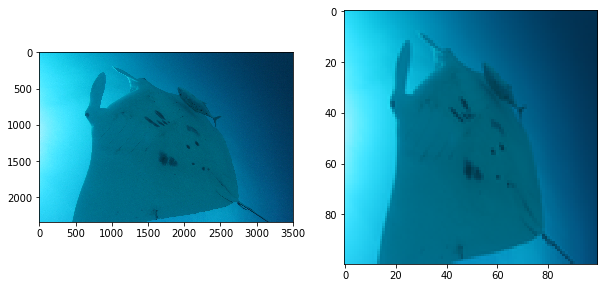

In [42]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


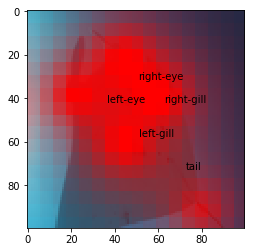

In [47]:
mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)

In [49]:
def flip_image(image,heatmaps):
    flip_image=image[::-1,:,]
    flip_heatmap=np.moveaxis(heatmaps[::-1,:,],-1,0)
    le,re,lg,rg,t=flip_heatmap
    flip_heatmap=np.array([re,le,rg,lg,t])
    flip_heatmap=np.moveaxis(flip_heatmap,0,-1)
    return flip_image,flip_heatmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


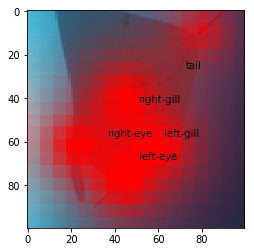

In [50]:
fi,fh=flip_image(mfp.denormalize(image1),heatmaps)
mfp.apply_heatmaps(fi,fh)

In [13]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    if image.shape[2]>3:
        image=image[:,:,:3]
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    #if image.shape[2]>3:
    #    image=image[:,:,:3]
        #print("\n More then 3 channels")
        #print(blm_path)
        #numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,:2])
        X.append(image) 
        #flip_img, flip_hm=flip_image(image,numpy_heatmaps)
        #y.append(flip_hm[:,:,:2])
        #X.append(flip_img) 
        
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115  
 Error on C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0012 Laverna\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json
116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 2

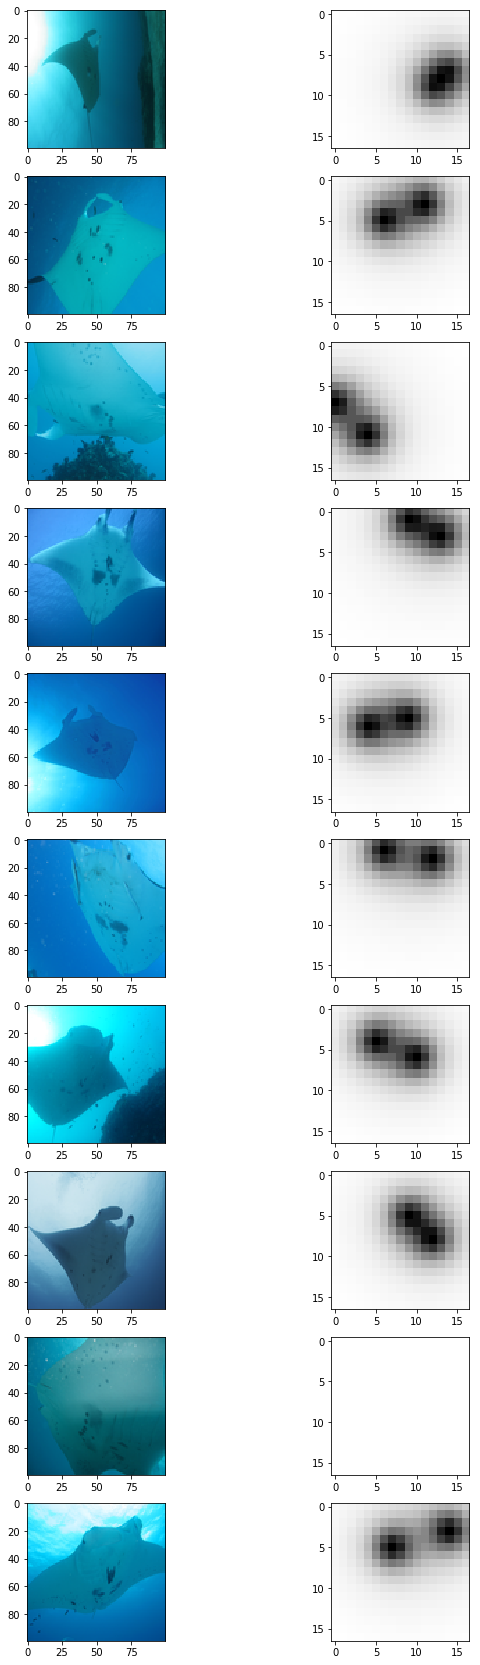

In [14]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s].sum(axis=2),cmap='Greys')
plt.show()

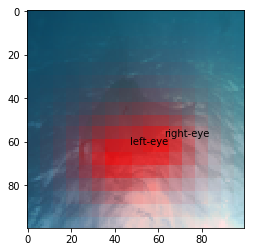

In [15]:
i=100
mfp.apply_heatmaps(mfp.denormalize(X[i]),y[i])
    

In [23]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [17]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [18]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [19]:
from tensorflow.keras.models import Model
mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [20]:
model=Sequential()
model.add(vgg16_net)
#model.add(mymodel)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=2,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 17, 17, 2)         578       
__________

In [21]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [25]:
start_time = time.time()
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=20)

history=model.fit(X_train,y_train,batch_size=32,epochs=500,validation_split=0.1,callbacks=[early_stopping_callback])

training_time=round(time.time() - start_time,2)

Train on 252 samples, validate on 28 samples
Epoch 1/500
252/252 [==============================] - 17s 69ms/step - loss: 0.7654 - binary_accuracy: 0.0585 - val_loss: 1.1678 - val_binary_accuracy: 0.0104
Epoch 2/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.7224 - binary_accuracy: 0.0731 - val_loss: 1.1169 - val_binary_accuracy: 0.0161
Epoch 3/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.7009 - binary_accuracy: 0.0766 - val_loss: 0.8633 - val_binary_accuracy: 0.0260
Epoch 4/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6880 - binary_accuracy: 0.0749 - val_loss: 0.7721 - val_binary_accuracy: 0.0301
Epoch 5/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 21ms/step - loss: 0.6787 - binary_accuracy: 0.0758 - val_loss: 0.7304 - val_binary_accuracy: 0.0315
Epoch 6/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6704 - binary_accuracy: 0.0775 - val_loss: 0.6992 - val_binary_accuracy: 0.0319
Epoch 7/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6656 - binary_accuracy: 0.0774 - val_loss: 0.6709 - val_binary_accuracy: 0.0323
Epoch 8/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6585 - binary_accuracy: 0.0773 - val_loss: 0.6531 - val_binary_accuracy: 0.0326
Epoch 9/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6525 - binary_accuracy: 0.0780 - val_loss: 0.6449 - val_binary_accuracy: 0.0329
Epoch 10/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 6s 22ms/step - loss: 0.6476 - binary_accuracy: 0.0788 - val_loss: 0.6377 - val_binary_accuracy: 0.0331
Epoch 11/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 6s 22ms/step - loss: 0.6425 - binary_accuracy: 0.0786 - val_loss: 0.6309 - val_binary_accuracy: 0.0332
Epoch 12/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6390 - binary_accuracy: 0.0786 - val_loss: 0.6245 - val_binary_accuracy: 0.0338
Epoch 13/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 6s 22ms/step - loss: 0.6345 - binary_accuracy: 0.0789 - val_loss: 0.6194 - val_binary_accuracy: 0.0339
Epoch 14/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6308 - binary_accuracy: 0.0791 - val_loss: 0.6157 - val_binary_accuracy: 0.0339
Epoch 15/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6269 - binary_accuracy: 0.0791 - val_loss: 0.6108 - val_binary_accuracy: 0.0340
Epoch 16/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6250 - binary_accuracy: 0.0792 - val_loss: 0.6058 - val_binary_accuracy: 0.0340
Epoch 17/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6202 - binary_accuracy: 0.0793 - val_loss: 0.6018 - val_binary_accuracy: 0.0342
Epoch 18/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6173 - binary_accuracy: 0.0793 - val_loss: 0.5985 - val_binary_accuracy: 0.0342
Epoch 19/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6142 - binary_accuracy: 0.0792 - val_loss: 0.5951 - val_binary_accuracy: 0.0344
Epoch 20/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6106 - binary_accuracy: 0.0793 - val_loss: 0.5927 - val_binary_accuracy: 0.0347
Epoch 21/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6087 - binary_accuracy: 0.0792 - val_loss: 0.5904 - val_binary_accuracy: 0.0342
Epoch 22/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6046 - binary_accuracy: 0.0793 - val_loss: 0.5874 - val_binary_accuracy: 0.0342
Epoch 23/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.6024 - binary_accuracy: 0.0794 - val_loss: 0.5866 - val_binary_accuracy: 0.0339
Epoch 24/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5998 - binary_accuracy: 0.0794 - val_loss: 0.5829 - val_binary_accuracy: 0.0344
Epoch 25/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5962 - binary_accuracy: 0.0794 - val_loss: 0.5822 - val_binary_accuracy: 0.0342
Epoch 26/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5942 - binary_accuracy: 0.0794 - val_loss: 0.5816 - val_binary_accuracy: 0.0336
Epoch 27/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5918 - binary_accuracy: 0.0794 - val_loss: 0.5787 - val_binary_accuracy: 0.0336
Epoch 28/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5891 - binary_accuracy: 0.0793 - val_loss: 0.5777 - val_binary_accuracy: 0.0336
Epoch 29/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5861 - binary_accuracy: 0.0793 - val_loss: 0.5749 - val_binary_accuracy: 0.0337
Epoch 30/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5846 - binary_accuracy: 0.0793 - val_loss: 0.5753 - val_binary_accuracy: 0.0334
Epoch 31/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5804 - binary_accuracy: 0.0794 - val_loss: 0.5740 - val_binary_accuracy: 0.0337
Epoch 32/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5775 - binary_accuracy: 0.0794 - val_loss: 0.5744 - val_binary_accuracy: 0.0330
Epoch 33/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5751 - binary_accuracy: 0.0794 - val_loss: 0.5726 - val_binary_accuracy: 0.0331
Epoch 34/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5721 - binary_accuracy: 0.0794 - val_loss: 0.5710 - val_binary_accuracy: 0.0330
Epoch 35/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5703 - binary_accuracy: 0.0794 - val_loss: 0.5676 - val_binary_accuracy: 0.0334
Epoch 36/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5671 - binary_accuracy: 0.0793 - val_loss: 0.5672 - val_binary_accuracy: 0.0333
Epoch 37/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5643 - binary_accuracy: 0.0794 - val_loss: 0.5646 - val_binary_accuracy: 0.0332
Epoch 38/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5618 - binary_accuracy: 0.0794 - val_loss: 0.5625 - val_binary_accuracy: 0.0336
Epoch 39/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5603 - binary_accuracy: 0.0794 - val_loss: 0.5623 - val_binary_accuracy: 0.0330
Epoch 40/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5570 - binary_accuracy: 0.0794 - val_loss: 0.5581 - val_binary_accuracy: 0.0331
Epoch 41/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5544 - binary_accuracy: 0.0794 - val_loss: 0.5614 - val_binary_accuracy: 0.0331
Epoch 42/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5529 - binary_accuracy: 0.0794 - val_loss: 0.5589 - val_binary_accuracy: 0.0331
Epoch 43/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5498 - binary_accuracy: 0.0794 - val_loss: 0.5614 - val_binary_accuracy: 0.0327
Epoch 44/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5477 - binary_accuracy: 0.0794 - val_loss: 0.5555 - val_binary_accuracy: 0.0327
Epoch 45/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5451 - binary_accuracy: 0.0794 - val_loss: 0.5576 - val_binary_accuracy: 0.0327
Epoch 46/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5428 - binary_accuracy: 0.0794 - val_loss: 0.5543 - val_binary_accuracy: 0.0327
Epoch 47/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5405 - binary_accuracy: 0.0793 - val_loss: 0.5526 - val_binary_accuracy: 0.0332
Epoch 48/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5380 - binary_accuracy: 0.0794 - val_loss: 0.5533 - val_binary_accuracy: 0.0327
Epoch 49/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5361 - binary_accuracy: 0.0794 - val_loss: 0.5477 - val_binary_accuracy: 0.0331
Epoch 50/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5334 - binary_accuracy: 0.0794 - val_loss: 0.5504 - val_binary_accuracy: 0.0329
Epoch 51/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5313 - binary_accuracy: 0.0794 - val_loss: 0.5469 - val_binary_accuracy: 0.0332
Epoch 52/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5288 - binary_accuracy: 0.0794 - val_loss: 0.5472 - val_binary_accuracy: 0.0331
Epoch 53/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5283 - binary_accuracy: 0.0793 - val_loss: 0.5450 - val_binary_accuracy: 0.0333
Epoch 54/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5247 - binary_accuracy: 0.0794 - val_loss: 0.5427 - val_binary_accuracy: 0.0334
Epoch 55/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5225 - binary_accuracy: 0.0794 - val_loss: 0.5425 - val_binary_accuracy: 0.0332
Epoch 56/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5204 - binary_accuracy: 0.0794 - val_loss: 0.5381 - val_binary_accuracy: 0.0331
Epoch 57/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5180 - binary_accuracy: 0.0794 - val_loss: 0.5412 - val_binary_accuracy: 0.0331
Epoch 58/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5163 - binary_accuracy: 0.0794 - val_loss: 0.5354 - val_binary_accuracy: 0.0334
Epoch 59/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5140 - binary_accuracy: 0.0794 - val_loss: 0.5357 - val_binary_accuracy: 0.0332
Epoch 60/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5120 - binary_accuracy: 0.0794 - val_loss: 0.5342 - val_binary_accuracy: 0.0331
Epoch 61/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5099 - binary_accuracy: 0.0794 - val_loss: 0.5322 - val_binary_accuracy: 0.0332
Epoch 62/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5076 - binary_accuracy: 0.0794 - val_loss: 0.5322 - val_binary_accuracy: 0.0331
Epoch 63/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5057 - binary_accuracy: 0.0794 - val_loss: 0.5282 - val_binary_accuracy: 0.0337
Epoch 64/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5039 - binary_accuracy: 0.0794 - val_loss: 0.5273 - val_binary_accuracy: 0.0331
Epoch 65/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5018 - binary_accuracy: 0.0794 - val_loss: 0.5252 - val_binary_accuracy: 0.0332
Epoch 66/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.5011 - binary_accuracy: 0.0794 - val_loss: 0.5248 - val_binary_accuracy: 0.0332
Epoch 67/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.4980 - binary_accuracy: 0.0794 - val_loss: 0.5219 - val_binary_accuracy: 0.0333
Epoch 68/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.4977 - binary_accuracy: 0.0794 - val_loss: 0.5221 - val_binary_accuracy: 0.0335
Epoch 69/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 6s 22ms/step - loss: 0.4944 - binary_accuracy: 0.0794 - val_loss: 0.5154 - val_binary_accuracy: 0.0335
Epoch 70/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.4923 - binary_accuracy: 0.0794 - val_loss: 0.5179 - val_binary_accuracy: 0.0336
Epoch 71/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 5s 22ms/step - loss: 0.4918 - binary_accuracy: 0.0793 - val_loss: 0.5133 - val_binary_accuracy: 0.0337
Epoch 72/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

252/252 [==============================] - 6s 22ms/step - loss: 0.4886 - binary_accuracy: 0.0794 - val_loss: 0.5119 - val_binary_accuracy: 0.0339
Epoch 73/500


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Dima\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Dima\Anaconda3\envs\tf\li

 64/252 [======>.......................] - ETA: 3s - loss: 0.4879 - binary_accuracy: 0.0859

KeyboardInterrupt: 

In [27]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

NameError: name 'history' is not defined

In [ ]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

In [ ]:
i=14
mfp.apply_heatmaps(mfp.denormalize(X_test[i]),pred[i])

In [ ]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s].sum(axis=2),cmap='Greys')
    axes[i,2].imshow(y_test[s].sum(axis=2),cmap='Greys')
plt.show()

In [ ]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling
